In [23]:
from __future__ import print_function    # (at top of module)
import requests
from furl import furl
from math import ceil
%matplotlib inline
from IPython.display import Image 
import matplotlib.pyplot as plt
import time
import timeit
import pandas as pd
import numpy as np
import re
import spotipy
import sys
import os
import json
import pprint
import seaborn as sns
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.oauth2 as oauth2
import spotipy.util as util
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

<h1>- Acquire the Data

## Spotify Api Auth 

In [6]:
cid = cid
secret = secret
username= username


client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

artist_name = []
track_name = []
track_id = [] 
popularity = []
album_name = []


for i in range(0,10000,50):
    track_results = sp.search(q='year:2018', type='track', limit=50,offset=i)
    for i, t in enumerate(track_results['tracks']['items']):
        artist_name.append(t['artists'][0]['name'])
        track_name.append(t['name'])
        track_id.append(t['id'])
        popularity.append(t['popularity'])
        album_name.append(t['album']['name'])
      



In [7]:
track_results

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=year%3A2018&type=track&offset=9950&limit=50',
  'items': [{'album': {'album_type': 'album',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/3famqI9bxiwLcAjRq3HuYl'},
       'href': 'https://api.spotify.com/v1/artists/3famqI9bxiwLcAjRq3HuYl',
       'id': '3famqI9bxiwLcAjRq3HuYl',
       'name': 'Riverdale Cast',
       'type': 'artist',
       'uri': 'spotify:artist:3famqI9bxiwLcAjRq3HuYl'}],
     'available_markets': ['AD',
      'AE',
      'AR',
      'AT',
      'AU',
      'BE',
      'BG',
      'BH',
      'BO',
      'BR',
      'CA',
      'CH',
      'CL',
      'CO',
      'CR',
      'CY',
      'CZ',
      'DE',
      'DK',
      'DO',
      'DZ',
      'EC',
      'EE',
      'EG',
      'ES',
      'FI',
      'FR',
      'GB',
      'GR',
      'GT',
      'HK',
      'HN',
      'HU',
      'ID',
      'IE',
      'IL',
      'IS',
      'IT',
      'JO',
      'JP',
      'KW'

In [ ]:
# get the artist names with Albums name and run through the Api to get the genre and then merge into the Df. 

In [933]:
print('number of elements in the track_name list:', len(track_name))

number of elements in the track_name list: 10000


In [5]:
# Get genres of artists
artist_genres = []     
for name in artist_name:
    genres = []
    artists = sp.search(q='artist:' + name, type='artist')
    genres.append(name)
    for i in range(len(artists['artists']['items'])):
        genre = artists['artists']['items'][i]['genres']
        if genre:
            genres.append(genre)

    artist_genres.append(genres)

retrying ...1secs


In [6]:
artist_genres[0:10]

[['Post Malone', ['dfw rap', 'pop', 'rap']],
 ['Post Malone', ['dfw rap', 'pop', 'rap']],
 ['Meek Mill',
  ['hip hop',
   'philly rap',
   'pop',
   'pop rap',
   'rap',
   'southern hip hop',
   'trap music']],
 ['YNW Melly', ['trap music']],
 ['Lil Baby', ['atl hip hop', 'atl trap', 'rap', 'trap music']],
 ['Calboy', ['chicago rap', 'trap music']],
 ['Travis Scott', ['pop', 'pop rap', 'rap']],
 ['Billie Eilish', ['electropop', 'pop']],
 ['Juice WRLD', ['chicago rap', 'trap music']],
 ['Marshmello', ['brostep', 'egyptian pop', 'progressive electro house']]]

In [ ]:
# flatten series with list values to multiple rows
df_expand = pd.DataFrame(df.column.tolist(), index=df.id).stack().reset_index(name=column)[["column","id"]]

In [312]:
df_test = pd.DataFrame({'artist_name':artist_name,'track_name':track_name,'album_name': album_name,'artist_genres':artist_genres,'track_id':track_id,'popularity':popularity})
print(df_test.shape)
df_test.head()


(10000, 6)


,artist_name,track_name,album_name,artist_genres,track_id,popularity
0,Post Malone,Sunflower - Spider-Man: Into the Spider-Verse,Spider-Man: Into the Spider-Verse (Soundtrack ...,"[Post Malone, [dfw rap, pop, rap]]",3KkXRkHbMCARz0aVfEt68P,94
1,Post Malone,Wow.,Wow.,"[Post Malone, [dfw rap, pop, rap]]",6MWtB6iiXyIwun0YzU6DFP,92
2,A Boogie Wit da Hoodie,Swervin (feat. 6ix9ine),Hoodie SZN,"[A Boogie Wit da Hoodie, [rap, trap music]]",1wJRveJZLSb1rjhnUHQiv6,90
3,Meek Mill,Going Bad (feat. Drake),Championships,"[Meek Mill, [hip hop, philly rap, pop, pop rap...",2IRZnDFmlqMuOrYOLnZZyc,88
4,YNW Melly,Murder On My Mind,I AM YOU,"[YNW Melly, [rap, trap music]]",7eBqSVxrzQZtK2mmgRG6lC,88


In [316]:
df_test.shape

(10000, 6)

## Spotify Audio Features

In [934]:
#measuring the time
start = timeit.default_timer()

# empty list, batchsize and the counter for None results
rows = []
batchsize = 100
None_counter = 0

for i in range(0,len(df_test['track_id']),batchsize):
    batch = df_test['track_id'][i:i+batchsize]
    feature_results = sp.audio_features(batch)
    for i, t in enumerate(feature_results):
        if t == None:
            None_counter = None_counter + 1
        else:
            rows.append(t)
            
print('Number of tracks where no audio features were available:',None_counter)

stop = timeit.default_timer()
print ('Time to run this code (in seconds):',stop - start)

Number of tracks where no audio features were available: 1
Time to run this code (in seconds): 20.540686538006412


In [935]:
print('number of elements in the track_id list:', len(rows))

number of elements in the track_id list: 9999


In [329]:
df_audio_features = pd.DataFrame.from_dict(rows,orient='columns')
print("Shape of the dataset:", df_audio_features.shape)
df_audio_features.head()

Shape of the dataset: (9999, 18)


,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,0.5560,https://api.spotify.com/v1/audio-analysis/3KkX...,0.760,158040,0.479,3KkXRkHbMCARz0aVfEt68P,0.000000,2,0.0703,-5.574,1,0.0466,89.911,4,https://api.spotify.com/v1/tracks/3KkXRkHbMCAR...,audio_features,spotify:track:3KkXRkHbMCARz0aVfEt68P,0.913
1,0.1630,https://api.spotify.com/v1/audio-analysis/6MWt...,0.833,149520,0.539,6MWtB6iiXyIwun0YzU6DFP,0.000002,11,0.1010,-7.399,0,0.1780,99.947,4,https://api.spotify.com/v1/tracks/6MWtB6iiXyIw...,audio_features,spotify:track:6MWtB6iiXyIwun0YzU6DFP,0.385
2,0.0153,https://api.spotify.com/v1/audio-analysis/1wJR...,0.581,189487,0.662,1wJRveJZLSb1rjhnUHQiv6,0.000000,9,0.1110,-5.239,1,0.3030,93.023,4,https://api.spotify.com/v1/tracks/1wJRveJZLSb1...,audio_features,spotify:track:1wJRveJZLSb1rjhnUHQiv6,0.434
3,0.2590,https://api.spotify.com/v1/audio-analysis/2IRZ...,0.889,180522,0.496,2IRZnDFmlqMuOrYOLnZZyc,0.000000,4,0.2520,-6.365,0,0.0905,86.003,4,https://api.spotify.com/v1/tracks/2IRZnDFmlqMu...,audio_features,spotify:track:2IRZnDFmlqMuOrYOLnZZyc,0.544
4,0.1450,https://api.spotify.com/v1/audio-analysis/7eBq...,0.759,268434,0.730,7eBqSVxrzQZtK2mmgRG6lC,0.000003,0,0.1100,-7.985,0,0.0516,115.007,4,https://api.spotify.com/v1/tracks/7eBqSVxrzQZt...,audio_features,spotify:track:7eBqSVxrzQZtK2mmgRG6lC,0.740


In [330]:
df_audio_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 18 columns):
acousticness        9999 non-null float64
analysis_url        9999 non-null object
danceability        9999 non-null float64
duration_ms         9999 non-null int64
energy              9999 non-null float64
id                  9999 non-null object
instrumentalness    9999 non-null float64
key                 9999 non-null int64
liveness            9999 non-null float64
loudness            9999 non-null float64
mode                9999 non-null int64
speechiness         9999 non-null float64
tempo               9999 non-null float64
time_signature      9999 non-null int64
track_href          9999 non-null object
type                9999 non-null object
uri                 9999 non-null object
valence             9999 non-null float64
dtypes: float64(9), int64(4), object(5)
memory usage: 1.4+ MB


<h1>- EDA

In [331]:
columns_to_drop = ['analysis_url','track_href','type','uri']
df_audio_features.drop(columns_to_drop, axis=1,inplace=True)

df_audio_features.rename(columns={'id': 'track_id'}, inplace=True)

In [332]:
df_audio_features.shape

(9999, 14)

In [333]:
df_audio_features.head()

,acousticness,danceability,duration_ms,energy,track_id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0.5560,0.760,158040,0.479,3KkXRkHbMCARz0aVfEt68P,0.000000,2,0.0703,-5.574,1,0.0466,89.911,4,0.913
1,0.1630,0.833,149520,0.539,6MWtB6iiXyIwun0YzU6DFP,0.000002,11,0.1010,-7.399,0,0.1780,99.947,4,0.385
2,0.0153,0.581,189487,0.662,1wJRveJZLSb1rjhnUHQiv6,0.000000,9,0.1110,-5.239,1,0.3030,93.023,4,0.434
3,0.2590,0.889,180522,0.496,2IRZnDFmlqMuOrYOLnZZyc,0.000000,4,0.2520,-6.365,0,0.0905,86.003,4,0.544
4,0.1450,0.759,268434,0.730,7eBqSVxrzQZtK2mmgRG6lC,0.000003,0,0.1100,-7.985,0,0.0516,115.007,4,0.740


In [334]:
df_audio_features.shape

(9999, 14)

In [124]:
df_audio_features.shape

(10000, 14)

### Merging the two Dataframes

In [136]:
# merge both dataframes
# the 'inner' method will make sure that we only keep track IDs present in both datasets
spotidata = pd.merge(df_test,df_audio_features,on='track_id',how='inner')
print("Shape of the dataset:", df_audio_features.shape)
spotidata.head()

Shape of the dataset: (10000, 14)


,artist_name,track_name,album_name,artist_genres,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Post Malone,Sunflower - Spider-Man: Into the Spider-Verse,Spider-Man: Into the Spider-Verse (Soundtrack ...,"[Post Malone, [pop, rap]]",3KkXRkHbMCARz0aVfEt68P,94,0.55600,0.760,158040,0.479,0.000000,2,0.0703,-5.574,1,0.0466,89.911,4,0.913
1,Meek Mill,Going Bad (feat. Drake),Championships,"[Meek Mill, [hip hop, philly rap, pop, pop rap...",2IRZnDFmlqMuOrYOLnZZyc,89,0.25900,0.889,180522,0.496,0.000000,4,0.2520,-6.365,0,0.0905,86.003,4,0.544
2,YNW Melly,Murder On My Mind,I AM YOU,"[YNW Melly, [trap music]]",7eBqSVxrzQZtK2mmgRG6lC,88,0.14500,0.759,268434,0.730,0.000003,0,0.1100,-7.985,0,0.0516,115.007,4,0.740
3,Calboy,Envy Me,Envy Me,"[Calboy, [chicago rap, trap music]]",05t7JMip6JrLuSrMV5yYjX,86,0.28200,0.556,120137,0.481,0.000000,11,0.2160,-7.663,1,0.3130,149.025,4,0.581
4,Travis Scott,SICKO MODE,ASTROWORLD,"[Travis Scott, [pop, pop rap, rap]]",2xLMifQCjDGFmkHkpNLD9h,88,0.00513,0.834,312820,0.730,0.000000,8,0.1240,-3.714,1,0.2220,155.008,4,0.446


<h3> check for Missing values

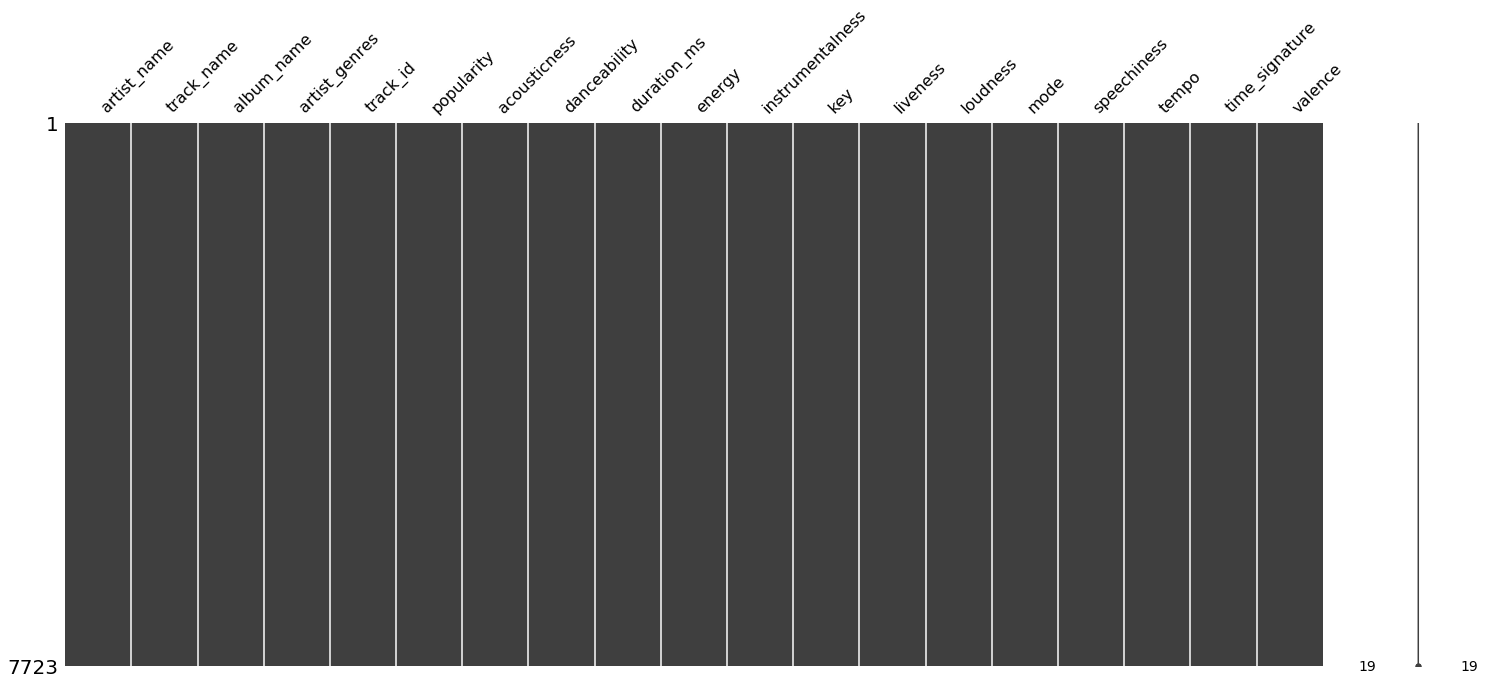

In [164]:
import missingno as msno
%matplotlib inline
msno.matrix(spotidata)

In [166]:
(spotidata.isna().sum()).sum()

0

In [137]:
spotidata.shape

(14838, 19)

In [138]:
spotidata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14838 entries, 0 to 14837
Data columns (total 19 columns):
artist_name         14838 non-null object
track_name          14838 non-null object
album_name          14838 non-null object
artist_genres       14838 non-null object
track_id            14838 non-null object
popularity          14838 non-null int64
acousticness        14838 non-null float64
danceability        14838 non-null float64
duration_ms         14838 non-null int64
energy              14838 non-null float64
instrumentalness    14838 non-null float64
key                 14838 non-null int64
liveness            14838 non-null float64
loudness            14838 non-null float64
mode                14838 non-null int64
speechiness         14838 non-null float64
tempo               14838 non-null float64
time_signature      14838 non-null int64
valence             14838 non-null float64
dtypes: float64(9), int64(5), object(5)
memory usage: 2.3+ MB


In [140]:

# group the entries by artist_name and track_name and check for duplicates

grouped = spotidata.groupby(['artist_name','track_name'], as_index=True).size()
grouped[grouped > 1].count()

1879

In [142]:
#There are 1879 duplicate entries which will be dropped in this cell
spotidata.drop_duplicates(subset=['artist_name','track_name'], inplace=True)


In [147]:
# verify the dropping
spotidata[spotidata.duplicated(subset=['artist_name','track_name'],keep=False)].count()

artist_name         0
track_name          0
album_name          0
artist_genres       0
track_id            0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64

In [115]:
spotidata[spotidata.duplicated(subset=['artist_name','track_name'],keep=False)]

,artist_name,track_name,album_name,artist_genres,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
2,YNW Melly,Murder On My Mind,I AM YOU,"[YNW Melly, [trap music]]",7eBqSVxrzQZtK2mmgRG6lC,88,0.14500,0.759,268434,0.730,0.000003,0,0.1100,-7.985,0,0.0516,115.007,4,0.740
3,Calboy,Envy Me,Envy Me,"[Calboy, [chicago rap, trap music]]",05t7JMip6JrLuSrMV5yYjX,86,0.28200,0.556,120137,0.481,0.000000,11,0.2160,-7.663,1,0.3130,149.025,4,0.581
8,21 Savage,a lot,i am > i was,"[21 Savage, [atl hip hop, rap, trap music]]",2t8yVaLvJ0RenpXUIAC52d,85,0.03950,0.837,288624,0.636,0.001250,1,0.3420,-7.643,1,0.0860,145.972,4,0.274
12,A Boogie Wit da Hoodie,Look Back At It,Hoodie SZN,"[A Boogie Wit da Hoodie, [rap, trap music]]",3Ol2xnObFdKV9pmRD2t9x8,85,0.40700,0.791,179449,0.587,0.000000,3,0.1480,-5.075,0,0.0413,96.057,4,0.536
22,benny blanco,Eastside (with Halsey & Khalid),Eastside (with Halsey & Khalid),"[benny blanco, [dance pop, pop, tropical house]]",0d2iYfpKoM0QCKvcLCkBao,86,0.55500,0.560,173800,0.680,0.000000,6,0.1160,-7.648,0,0.3210,89.391,4,0.319
27,Drake,Nonstop,Scorpion,"[Drake, [canadian hip hop, canadian pop, hip h...",0TlLq3lA83rQOYtrqBqSct,84,0.01640,0.912,238614,0.412,0.013000,7,0.1040,-8.074,1,0.1240,154.983,4,0.422
28,Cardi B,I Like It,Invasion of Privacy,"[Cardi B, [pop, rap]]",58q2HKrzhC3ozto2nDdN4z,86,0.09900,0.816,253390,0.726,0.000000,5,0.3720,-3.998,0,0.1290,136.048,4,0.650
29,Lil Mosey,Noticed,Northsbest,"[Lil Mosey, [rap conscient, trap music, vapor ...",6JQvHMSaR8flFsN53ypOfP,83,0.46200,0.699,165000,0.558,0.000000,11,0.1160,-7.622,1,0.0603,79.992,4,0.493
34,Lady Gaga,Shallow,A Star Is Born Soundtrack,"[Lady Gaga, [dance pop, pop], [fake]]",2VxeLyX666F8uXCJ0dZF8B,91,0.37100,0.572,215733,0.385,0.000000,7,0.2310,-6.362,1,0.0308,95.799,4,0.323
46,Luke Combs,She Got the Best of Me,This One's for You Too (Deluxe Edition),"[Luke Combs, [contemporary country, country ro...",698eQRku24PIYPQPHItKlA,78,0.02920,0.533,183160,0.907,0.000000,11,0.3860,-3.793,1,0.0406,150.990,4,0.700


In [144]:
spotidata.shape

(7723, 19)

In [149]:
spotidata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7723 entries, 0 to 14837
Data columns (total 19 columns):
artist_name         7723 non-null object
track_name          7723 non-null object
album_name          7723 non-null object
artist_genres       7723 non-null object
track_id            7723 non-null object
popularity          7723 non-null int64
acousticness        7723 non-null float64
danceability        7723 non-null float64
duration_ms         7723 non-null int64
energy              7723 non-null float64
instrumentalness    7723 non-null float64
key                 7723 non-null int64
liveness            7723 non-null float64
loudness            7723 non-null float64
mode                7723 non-null int64
speechiness         7723 non-null float64
tempo               7723 non-null float64
time_signature      7723 non-null int64
valence             7723 non-null float64
dtypes: float64(9), int64(5), object(5)
memory usage: 1.2+ MB


In [135]:
print(spotipop.shape)
print(spotipop.info())
spotipop.head()

(7723, 19)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7723 entries, 0 to 14837
Data columns (total 19 columns):
artist_name         7723 non-null object
track_name          7723 non-null object
album_name          7723 non-null object
artist_genres       7723 non-null object
track_id            7723 non-null object
popularity          7723 non-null int64
acousticness        7723 non-null float64
danceability        7723 non-null float64
duration_ms         7723 non-null int64
energy              7723 non-null float64
instrumentalness    7723 non-null float64
key                 7723 non-null int64
liveness            7723 non-null float64
loudness            7723 non-null float64
mode                7723 non-null int64
speechiness         7723 non-null float64
tempo               7723 non-null float64
time_signature      7723 non-null int64
valence             7723 non-null float64
dtypes: float64(9), int64(5), object(5)
memory usage: 1.2+ MB
None


,artist_name,track_name,album_name,artist_genres,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Post Malone,Sunflower - Spider-Man: Into the Spider-Verse,Spider-Man: Into the Spider-Verse (Soundtrack ...,"[Post Malone, [pop, rap]]",3KkXRkHbMCARz0aVfEt68P,94,0.55600,0.760,158040,0.479,0.000000,2,0.0703,-5.574,1,0.0466,89.911,4,0.913
1,Meek Mill,Going Bad (feat. Drake),Championships,"[Meek Mill, [hip hop, philly rap, pop, pop rap...",2IRZnDFmlqMuOrYOLnZZyc,89,0.25900,0.889,180522,0.496,0.000000,4,0.2520,-6.365,0,0.0905,86.003,4,0.544
2,YNW Melly,Murder On My Mind,I AM YOU,"[YNW Melly, [trap music]]",7eBqSVxrzQZtK2mmgRG6lC,88,0.14500,0.759,268434,0.730,0.000003,0,0.1100,-7.985,0,0.0516,115.007,4,0.740
3,Calboy,Envy Me,Envy Me,"[Calboy, [chicago rap, trap music]]",05t7JMip6JrLuSrMV5yYjX,86,0.28200,0.556,120137,0.481,0.000000,11,0.2160,-7.663,1,0.3130,149.025,4,0.581
4,Travis Scott,SICKO MODE,ASTROWORLD,"[Travis Scott, [pop, pop rap, rap]]",2xLMifQCjDGFmkHkpNLD9h,88,0.00513,0.834,312820,0.730,0.000000,8,0.1240,-3.714,1,0.2220,155.008,4,0.446


In [159]:
# Save the Dataframe
spotidata.to_csv('spotidata.csv', index=False) 

In [132]:
spotidata = pd.read_csv('spotidata.csv')

In [133]:
spotidata.head()

,artist_name,track_name,album_name,artist_genres,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Post Malone,Sunflower - Spider-Man: Into the Spider-Verse,Spider-Man: Into the Spider-Verse (Soundtrack ...,"['Post Malone', ['pop', 'rap']]",3KkXRkHbMCARz0aVfEt68P,94,0.55600,0.760,158040,0.479,0.000000,2,0.0703,-5.574,1,0.0466,89.911,4,0.913
1,Meek Mill,Going Bad (feat. Drake),Championships,"['Meek Mill', ['hip hop', 'philly rap', 'pop',...",2IRZnDFmlqMuOrYOLnZZyc,89,0.25900,0.889,180522,0.496,0.000000,4,0.2520,-6.365,0,0.0905,86.003,4,0.544
2,YNW Melly,Murder On My Mind,I AM YOU,"['YNW Melly', ['trap music']]",7eBqSVxrzQZtK2mmgRG6lC,88,0.14500,0.759,268434,0.730,0.000003,0,0.1100,-7.985,0,0.0516,115.007,4,0.740
3,Calboy,Envy Me,Envy Me,"['Calboy', ['chicago rap', 'trap music']]",05t7JMip6JrLuSrMV5yYjX,86,0.28200,0.556,120137,0.481,0.000000,11,0.2160,-7.663,1,0.3130,149.025,4,0.581
4,Travis Scott,SICKO MODE,ASTROWORLD,"['Travis Scott', ['pop', 'pop rap', 'rap']]",2xLMifQCjDGFmkHkpNLD9h,88,0.00513,0.834,312820,0.730,0.000000,8,0.1240,-3.714,1,0.2220,155.008,4,0.446


In [134]:
spotidata["artist_genres"]

0                         ['Post Malone', ['pop', 'rap']]
1       ['Meek Mill', ['hip hop', 'philly rap', 'pop',...
2                           ['YNW Melly', ['trap music']]
3               ['Calboy', ['chicago rap', 'trap music']]
4             ['Travis Scott', ['pop', 'pop rap', 'rap']]
5       ['Halsey', ['dance pop', 'electropop', 'etherp...
6       ['Marshmello', ['brostep', 'egyptian pop', 'pr...
7                         ['Juice WRLD', ['chicago rap']]
8       ['21 Savage', ['atl hip hop', 'rap', 'trap mus...
9       ['Khalid', ['pop'], ['pakistani pop'], ['somal...
10                        ['Post Malone', ['pop', 'rap']]
11         ['XXXTENTACION', ['emo rap', 'miami hip hop']]
12      ['A Boogie Wit da Hoodie', ['rap', 'trap music']]
13      ['Panic! At The Disco', ['emo', 'modern rock',...
14      ['Sheck Wes', ['rap', 'trap music', 'undergrou...
15      ['Kodak Black', ['miami hip hop', 'pop rap', '...
16                        ['Juice WRLD', ['chicago rap']]
17      ['Flip

In [11]:
# create new dataframe df_pop ordered consisting of the 20 most popular tracks
df_pop = spotidata.sort_values('popularity', ascending=False)

In [12]:
df_pop.reset_index(inplace = True) 

In [13]:
df_pop.head()

,index,artist_name,track_name,album_name,artist_genres,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0,Post Malone,Sunflower - Spider-Man: Into the Spider-Verse,Spider-Man: Into the Spider-Verse (Soundtrack ...,"['Post Malone', ['pop', 'rap']]",3KkXRkHbMCARz0aVfEt68P,94,0.556000,0.760,158040,0.4790,0.000000,2,0.0703,-5.574,1,0.0466,89.911,4,0.91300
1,62,Pedro Capó,Calma - Remix,Calma (Remix),"['Pedro Capó', ['latin pop']]",5iwz1NiezX7WWjnCgY5TH4,91,0.323000,0.826,238200,0.7730,0.000000,11,0.1430,-4.218,0,0.0524,126.899,4,0.76100
2,34,Lady Gaga,Shallow,A Star Is Born Soundtrack,"['Lady Gaga', ['dance pop', 'pop'], ['fake']]",2VxeLyX666F8uXCJ0dZF8B,91,0.371000,0.572,215733,0.3850,0.000000,7,0.2310,-6.362,1,0.0308,95.799,4,0.32300
3,5,Halsey,Without Me,Without Me,"['Halsey', ['dance pop', 'electropop', 'etherp...",5p7ujcrUXASCNwRaWNHR1C,91,0.297000,0.752,201661,0.4880,0.000009,6,0.0936,-7.050,1,0.0705,136.041,4,0.53300
4,6,Marshmello,Happier,Happier,"['Marshmello', ['brostep', 'egyptian pop', 'pr...",2dpaYNEQHiRxtZbfNsse99,91,0.191000,0.687,214290,0.7920,0.000000,5,0.1670,-2.749,1,0.0452,100.015,4,0.67100
5,54,Lewis Capaldi,Someone You Loved,Breach,"['Lewis Capaldi', ['pop', 'uk pop']]",2TIlqbIneP0ZY1O0EzYLlc,90,0.751000,0.501,182161,0.4050,0.000000,1,0.1050,-5.679,1,0.0319,109.891,4,0.44600
6,13,Panic! At The Disco,High Hopes,Pray For The Wicked,"['Panic! At The Disco', ['emo', 'modern rock',...",1rqqCSm0Qe4I9rUvWncaom,89,0.193000,0.579,190947,0.9040,0.000000,5,0.0640,-2.729,1,0.0618,82.014,4,0.68100
7,1,Meek Mill,Going Bad (feat. Drake),Championships,"['Meek Mill', ['hip hop', 'philly rap', 'pop',...",2IRZnDFmlqMuOrYOLnZZyc,89,0.259000,0.889,180522,0.4960,0.000000,4,0.2520,-6.365,0,0.0905,86.003,4,0.54400
8,31,Alec Benjamin,Let Me Down Slowly,Narrated For You,"['Alec Benjamin', ['pop']]",2qxmye6gAegTMjLKEBoR3d,89,0.740000,0.652,169354,0.5570,0.000000,1,0.1240,-5.714,0,0.0318,150.073,4,0.48300
9,10,Post Malone,Better Now,beerbongs & bentleys,"['Post Malone', ['pop', 'rap']]",7dt6x5M1jzdTEt8oCbisTK,88,0.354000,0.680,231267,0.5630,0.000000,10,0.1360,-5.843,1,0.0454,145.028,4,0.37400


In [ ]:
# The popularity of a track is a value between 0 and 100, with 100 being the most popular. 
# The popularity is calculated by algorithm and is based, in the most part, on the total number of plays 
# the track has had and how recent those plays are.
# Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were 
# played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. 
# Artist and album popularity is derived mathematically from track popularity. Note that the popularity value may 
# lag actual popularity by a few days: the value is not updated in real time.

In [19]:
# Create categorical values for "Popularity" : 0 = unpopular , 1 = Popular , 2 = Very Popular
bins = [0, 50, 68, 100]
df_pop['binned'] = pd.cut(df_pop['popularity'], bins)

In [20]:
bins = [0, 50, 68, 100]
labels = [0,1,2]
df_pop['binned'] = pd.cut(df_pop['popularity'], bins=bins, labels=labels)

In [22]:
# create a new DF with the new binned/classified popularity score 
df_popular = df_pop

In [23]:
#rename the binned coulmn as Popular

df_popular.rename(columns={'binned':'Popular'},inplace=True)

In [24]:
#drop the the popularity column and rename the binned one as Popular
df_popular[df_popular.columns.drop('popularity')]
df_popular = df_popular[df_popular.columns.drop('popularity')]

In [25]:
df_popular.head()

,index,artist_name,track_name,album_name,artist_genres,track_id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,Popular
0,0,Post Malone,Sunflower - Spider-Man: Into the Spider-Verse,Spider-Man: Into the Spider-Verse (Soundtrack ...,"['Post Malone', ['pop', 'rap']]",3KkXRkHbMCARz0aVfEt68P,0.556000,0.760,158040,0.4790,0.000000,2,0.0703,-5.574,1,0.0466,89.911,4,0.91300,2
1,62,Pedro Capó,Calma - Remix,Calma (Remix),"['Pedro Capó', ['latin pop']]",5iwz1NiezX7WWjnCgY5TH4,0.323000,0.826,238200,0.7730,0.000000,11,0.1430,-4.218,0,0.0524,126.899,4,0.76100,2
2,34,Lady Gaga,Shallow,A Star Is Born Soundtrack,"['Lady Gaga', ['dance pop', 'pop'], ['fake']]",2VxeLyX666F8uXCJ0dZF8B,0.371000,0.572,215733,0.3850,0.000000,7,0.2310,-6.362,1,0.0308,95.799,4,0.32300,2
3,5,Halsey,Without Me,Without Me,"['Halsey', ['dance pop', 'electropop', 'etherp...",5p7ujcrUXASCNwRaWNHR1C,0.297000,0.752,201661,0.4880,0.000009,6,0.0936,-7.050,1,0.0705,136.041,4,0.53300,2
4,6,Marshmello,Happier,Happier,"['Marshmello', ['brostep', 'egyptian pop', 'pr...",2dpaYNEQHiRxtZbfNsse99,0.191000,0.687,214290,0.7920,0.000000,5,0.1670,-2.749,1,0.0452,100.015,4,0.67100,2
5,54,Lewis Capaldi,Someone You Loved,Breach,"['Lewis Capaldi', ['pop', 'uk pop']]",2TIlqbIneP0ZY1O0EzYLlc,0.751000,0.501,182161,0.4050,0.000000,1,0.1050,-5.679,1,0.0319,109.891,4,0.44600,2
6,13,Panic! At The Disco,High Hopes,Pray For The Wicked,"['Panic! At The Disco', ['emo', 'modern rock',...",1rqqCSm0Qe4I9rUvWncaom,0.193000,0.579,190947,0.9040,0.000000,5,0.0640,-2.729,1,0.0618,82.014,4,0.68100,2
7,1,Meek Mill,Going Bad (feat. Drake),Championships,"['Meek Mill', ['hip hop', 'philly rap', 'pop',...",2IRZnDFmlqMuOrYOLnZZyc,0.259000,0.889,180522,0.4960,0.000000,4,0.2520,-6.365,0,0.0905,86.003,4,0.54400,2
8,31,Alec Benjamin,Let Me Down Slowly,Narrated For You,"['Alec Benjamin', ['pop']]",2qxmye6gAegTMjLKEBoR3d,0.740000,0.652,169354,0.5570,0.000000,1,0.1240,-5.714,0,0.0318,150.073,4,0.48300,2
9,10,Post Malone,Better Now,beerbongs & bentleys,"['Post Malone', ['pop', 'rap']]",7dt6x5M1jzdTEt8oCbisTK,0.354000,0.680,231267,0.5630,0.000000,10,0.1360,-5.843,1,0.0454,145.028,4,0.37400,2


In [15]:
import ast
# An Abstract Syntax-Tree is a data structure that represents a piece of code in a hierarchical manner, 
# and it greatly facilitates reasoning, analyzing, and even modifying the code in an automated way.

In [16]:
# Break or flatten the values of the column 
df_pop["artist_genres"] = df_pop["artist_genres"].apply(lambda x: ast.literal_eval(x))

In [25]:
df_pop.artist_genres[0]

['Post Malone', ['pop', 'rap']]

In [20]:
# flatten series with list values to multiple rows
df_G = pd.DataFrame(df_pop.artist_genres.tolist(), index=df_pop["index"]).stack().reset_index(name="artist_genres")

In [21]:
df_G.head()

,index,level_1,artist_genres
0,0,0,Post Malone
1,0,1,"[pop, rap]"
2,62,0,Pedro Capó
3,62,1,[latin pop]
4,34,0,Lady Gaga


In [22]:
df_G.artist_genres[0]

'Post Malone'

In [23]:
# drop all the artist names by droping values == 0 from the df  
# df_G.loc[df_G.level_1 == 0] 

df_G.drop(df_G.index[df_G['level_1'] == 0], inplace = True)

In [24]:
df_G.head()

,index,level_1,artist_genres
1,0,1,"[pop, rap]"
3,62,1,[latin pop]
5,34,1,"[dance pop, pop]"
6,34,2,[fake]
8,5,1,"[dance pop, electropop, etherpop, indie poptim..."


In [26]:
df_G1 = df_G

In [27]:
#flatten to the final value for artist_genre
df_G1 = pd.DataFrame(df_G.artist_genres.tolist(), index=df_G["index"]).stack().reset_index(name="artist_genres")

In [28]:
df_G1.head()

,index,level_1,artist_genres
0,0,0,pop
1,0,1,rap
2,62,0,latin pop
3,34,0,dance pop
4,34,1,pop
5,34,0,fake
6,5,0,dance pop
7,5,1,electropop
8,5,2,etherpop
9,5,3,indie poptimism


In [40]:

df_G1[df_G1['artist_genres'].str.match('pop')]

,index,level_1,artist_genres
0,0,0,pop
4,34,1,pop
10,5,4,pop
15,54,0,pop
19,13,2,pop punk
22,1,2,pop
23,1,3,pop rap
27,31,0,pop
28,10,0,pop
30,4,0,pop


In [29]:
sp.recommendation_genre_seeds()

{'genres': ['acoustic',
  'afrobeat',
  'alt-rock',
  'alternative',
  'ambient',
  'anime',
  'black-metal',
  'bluegrass',
  'blues',
  'bossanova',
  'brazil',
  'breakbeat',
  'british',
  'cantopop',
  'chicago-house',
  'children',
  'chill',
  'classical',
  'club',
  'comedy',
  'country',
  'dance',
  'dancehall',
  'death-metal',
  'deep-house',
  'detroit-techno',
  'disco',
  'disney',
  'drum-and-bass',
  'dub',
  'dubstep',
  'edm',
  'electro',
  'electronic',
  'emo',
  'folk',
  'forro',
  'french',
  'funk',
  'garage',
  'german',
  'gospel',
  'goth',
  'grindcore',
  'groove',
  'grunge',
  'guitar',
  'happy',
  'hard-rock',
  'hardcore',
  'hardstyle',
  'heavy-metal',
  'hip-hop',
  'holidays',
  'honky-tonk',
  'house',
  'idm',
  'indian',
  'indie',
  'indie-pop',
  'industrial',
  'iranian',
  'j-dance',
  'j-idol',
  'j-pop',
  'j-rock',
  'jazz',
  'k-pop',
  'kids',
  'latin',
  'latino',
  'malay',
  'mandopop',
  'metal',
  'metal-misc',
  'metalcore',


In [43]:
#check for all genre that includes "pop"
df_G2 = df_G1.apply(lambda x: 'pop' if 'pop' in x else x)


In [61]:
print(type(df_G2))

<class 'pandas.core.frame.DataFrame'>


In [44]:
df_G2

,index,level_1,artist_genres
0,0,0,pop
1,0,1,rap
2,62,0,latin pop
3,34,0,dance pop
4,34,1,pop
5,34,0,fake
6,5,0,dance pop
7,5,1,electropop
8,5,2,etherpop
9,5,3,indie poptimism


In [62]:
#replace all the genre that includes "pop" genres to "pop"
df_G2['artist_genres'] = df_G2.artist_genres.str.replace(r'(^.*pop.*$)', 'pop')
df_G2

,index,level_1,artist_genres
0,0,0,pop
1,0,1,rap
2,62,0,pop
3,34,0,pop
4,34,1,pop
5,34,0,fake
6,5,0,pop
7,5,1,pop
8,5,2,pop
9,5,3,pop


In [338]:
df_G2.head()

,index,level_1,artist_genres
0,0,0,pop
1,0,1,rap
2,62,0,pop
3,34,0,pop
4,34,1,pop


In [147]:
# get the the word that occur the most and get the top 10 genre from that.
df_G2['artist_genres'].describe()

count     34752
unique     1262
top         pop
freq       8721
Name: artist_genres, dtype: object

In [79]:
# merge both dataframes
# the 'inner' method will make sure that we only keep track IDs present in both datasets
df_genre = pd.merge(df_G2,df_popular,on='index',how='inner')

In [81]:
df_genre.rename(columns={'artist_genres_x':'artist_genres','artist_genres_y':'All_genres'},inplace=True)

In [85]:
df_genre = df_genre[df_genre.columns.drop('level_1','instrumentalness')]


In [89]:
#reorder the columns
df_genre = df_genre[["index",'artist_name','artist_genres',
                     'album_name','track_name',
                     "All_genres","track_id",'Popular','acousticness','danceability',
                     'duration_ms','energy','key','liveness','loudness',
                     'speechiness','tempo','time_signature','valence']]



In [126]:
df_genre['artist_genres'].unique().shape

(1335,)

In [91]:
#save the Dataframe
df_genre.to_csv('df_genre.csv', index=False) 

In [8]:
df_genre = pd.read_csv('df_genre.csv')

In [9]:
df_genre['artist_genres'] = df_genre.artist_genres.str.replace(r'(^.*blues.*$)', 'blues')


In [10]:
df_genre['artist_genres'].value_counts()

pop                             8721
rap                             1073
trap music                      1018
southern hip hop                 691
hip hop                          620
blues                            506
underground hip hop              481
edm                              441
modern rock                      399
vapor trap                       382
r&b                              375
tropical house                   359
electro house                    309
lo-fi beats                      300
contemporary country             278
indie r&b                        275
alternative r&b                  274
indie folk                       239
atl hip hop                      213
emo rap                          207
latin                            199
indietronica                     180
chillhop                         178
rock                             175
cali rap                         172
reggaeton flow                   167
indie rock                       165
b

In [15]:
df_genre.shape

NameError: name 'df_genre' is not defined

In [284]:
# Create a Dataframe with the 12 genres: [pop,rap,hip hop,rock,house,r&b,indie,country,latin,metal,folk,blues]
Top_Genre = df_genre[df_genre['artist_genres'].isin(['pop', 'rap',"hip hop","rock","house","r&b","indie",
                                                     "country","latin","metal","folk","blues"])]

In [1]:
Top_Genre.head()

NameError: name 'Top_Genre' is not defined

In [297]:
grouped = Top_Genre.groupby(['artist_name','track_name'], as_index=True).size()
grouped[grouped > 1].count()

5413

In [298]:
#There are 5413 duplicate entries which will be dropped in this cell
Top_Genre.drop_duplicates(subset=['artist_name','track_name'], inplace=True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [299]:
# check for any duplicates and drop them
Top_Genre[Top_Genre.duplicated(subset=['artist_name','track_name'],keep=False)].count()

index             0
artist_name       0
artist_genres     0
album_name        0
track_name        0
All_genres        0
track_id          0
Popular           0
acousticness      0
danceability      0
duration_ms       0
energy            0
key               0
liveness          0
loudness          0
speechiness       0
tempo             0
time_signature    0
valence           0
dtype: int64

In [300]:
Top_Genre["track_name"].unique

<bound method Series.unique of 0        Sunflower - Spider-Man: Into the Spider-Verse
2                                        Calma - Remix
3                                              Shallow
6                                           Without Me
12                                             Happier
15                                   Someone You Loved
18                                          High Hopes
20                             Going Bad (feat. Drake)
27                                  Let Me Down Slowly
28                                          Better Now
30                                          SICKO MODE
33                                               Te Vi
35                                   MIA (feat. Drake)
37                                   Murder On My Mind
38                                            3 Nights
39                                        Lucid Dreams
40                                          Be Alright
42                                

In [336]:
Top_Genre.head()

,index,artist_name,artist_genres,album_name,track_name,All_genres,track_id,Popular,acousticness,danceability,duration_ms,energy,key,liveness,loudness,speechiness,tempo,time_signature,valence
0,0,Post Malone,pop,Spider-Man: Into the Spider-Verse (Soundtrack ...,Sunflower - Spider-Man: Into the Spider-Verse,"[Post Malone, [pop, rap]]",3KkXRkHbMCARz0aVfEt68P,2,0.556,0.760,158040,0.479,2,0.0703,-5.574,0.0466,89.911,4,0.913
2,62,Pedro Capó,pop,Calma (Remix),Calma - Remix,"[Pedro Capó, [latin pop]]",5iwz1NiezX7WWjnCgY5TH4,2,0.323,0.826,238200,0.773,11,0.1430,-4.218,0.0524,126.899,4,0.761
3,34,Lady Gaga,pop,A Star Is Born Soundtrack,Shallow,"[Lady Gaga, [dance pop, pop], [fake]]",2VxeLyX666F8uXCJ0dZF8B,2,0.371,0.572,215733,0.385,7,0.2310,-6.362,0.0308,95.799,4,0.323
6,5,Halsey,pop,Without Me,Without Me,"[Halsey, [dance pop, electropop, etherpop, ind...",5p7ujcrUXASCNwRaWNHR1C,2,0.297,0.752,201661,0.488,6,0.0936,-7.050,0.0705,136.041,4,0.533
12,6,Marshmello,house,Happier,Happier,"[Marshmello, [brostep, egyptian pop, progressi...",2dpaYNEQHiRxtZbfNsse99,2,0.191,0.687,214290,0.792,5,0.1670,-2.749,0.0452,100.015,4,0.671


In [363]:
Top_Genre= Top_Genre.reset_index(drop=True)

In [366]:
# Save the Dataframe 
Top_Genre.to_csv('Top_Genre.csv', index=False) 

In [111]:
Top_Genre = pd.read_csv("Top_Genre.csv")

In [112]:
Top_Genre.head()
Top_Genre.shape

(6629, 19)

In [113]:
Top_Genre["artist_genres"].value_counts()

pop        1931
hip hop    1121
rap        1003
rock        581
house       437
r&b         406
latin       329
country     274
metal       205
indie       194
blues        80
folk         68
Name: artist_genres, dtype: int64

In [368]:
# Create a set of dummy variables from the artist_genres variable
genre_matrix = pd.get_dummies(Top_Genre["artist_genres"])

In [369]:
genre_matrix.head()

,blues,country,folk,hip hop,house,indie,latin,metal,pop,r&b,rap,rock
0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0


In [372]:
# Join the dummy variables to the main dataframe
spotifinal = pd.concat([Top_Genre, genre_matrix], axis=1)
spotifinal.head()


,index,artist_name,artist_genres,album_name,track_name,All_genres,track_id,Popular,acousticness,danceability,...,folk,hip hop,house,indie,latin,metal,pop,r&b,rap,rock
0,0,Post Malone,pop,Spider-Man: Into the Spider-Verse (Soundtrack ...,Sunflower - Spider-Man: Into the Spider-Verse,"[Post Malone, [pop, rap]]",3KkXRkHbMCARz0aVfEt68P,2,0.556,0.760,...,0,0,0,0,0,0,1,0,0,0
1,62,Pedro Capó,pop,Calma (Remix),Calma - Remix,"[Pedro Capó, [latin pop]]",5iwz1NiezX7WWjnCgY5TH4,2,0.323,0.826,...,0,0,0,0,0,0,1,0,0,0
2,34,Lady Gaga,pop,A Star Is Born Soundtrack,Shallow,"[Lady Gaga, [dance pop, pop], [fake]]",2VxeLyX666F8uXCJ0dZF8B,2,0.371,0.572,...,0,0,0,0,0,0,1,0,0,0
3,5,Halsey,pop,Without Me,Without Me,"[Halsey, [dance pop, electropop, etherpop, ind...",5p7ujcrUXASCNwRaWNHR1C,2,0.297,0.752,...,0,0,0,0,0,0,1,0,0,0
4,6,Marshmello,house,Happier,Happier,"[Marshmello, [brostep, egyptian pop, progressi...",2dpaYNEQHiRxtZbfNsse99,2,0.191,0.687,...,0,0,1,0,0,0,0,0,0,0


In [423]:
spotifinal.columns

Index(['index', 'artist_name', 'artist_genres', 'album_name', 'track_name',
       'All_genres', 'track_id', 'Popular', 'acousticness', 'danceability',
       'duration_ms', 'energy', 'key', 'liveness', 'loudness', 'speechiness',
       'tempo', 'time_signature', 'valence', 'blues', 'country', 'folk',
       'hip hop', 'house', 'indie', 'latin', 'metal', 'pop', 'r&b', 'rap',
       'rock'],
      dtype='object')

In [431]:
#check the dataframe for specific genre 
spotifinal[spotifinal['rock']>0.5]

,index,artist_name,artist_genres,album_name,track_name,All_genres,track_id,Popular,acousticness,danceability,...,folk,hip hop,house,indie,latin,metal,pop,r&b,rap,rock
6,13,Panic! At The Disco,rock,Pray For The Wicked,High Hopes,"[Panic! At The Disco, [emo, modern rock, pop p...",1rqqCSm0Qe4I9rUvWncaom,2,0.193000,0.579,...,0,0,0,0,0,0,0,0,0,1
22,42,Kina,rock,Get You The Moon (feat. Snøw),Get You The Moon (feat. Snøw),"[Kina, [lo-fi beats], [acoustic pop, folk-pop,...",4ZLzoOkj0MPWrTLvooIuaa,2,0.720000,0.498,...,0,0,0,0,0,0,0,0,0,1
39,20,Panic! At The Disco,rock,Pray For The Wicked,"Hey Look Ma, I Made It","[Panic! At The Disco, [emo, modern rock, pop p...",22oEJW6r2rMb9z4IntfyEa,2,0.013700,0.577,...,0,0,0,0,0,0,0,0,0,1
264,301,The 1975,rock,A Brief Inquiry Into Online Relationships,It's Not Living (If It's Not With You),"[The 1975, [modern alternative rock, nu gaze, ...",3TgMcrV32NUKjEG2ujn9eh,2,0.000297,0.618,...,0,0,0,0,0,0,0,0,0,1
267,512,Imagine Dragons,rock,Origins (Deluxe),"Zero - From the Original Motion Picture ""Ralph...","[Imagine Dragons, [modern rock, rock]]",2bzitsPcImYC6DZWvvLCQi,2,0.000479,0.634,...,0,0,0,0,0,0,0,0,0,1
312,230,Panic! At The Disco,rock,Pray For The Wicked,Say Amen (Saturday Night),"[Panic! At The Disco, [emo, modern rock, pop p...",76vMKwFtdDDCLcM6zXybjB,2,0.167000,0.491,...,0,0,0,0,0,0,0,0,0,1
315,113,AJR,rock,The Click (Deluxe Edition),Burn the House Down,"[AJR, [modern rock, pop], [tamborazo]]",0j7pdNXDzEVQST5Zcoh5xo,2,0.036400,0.454,...,0,0,0,0,0,0,0,0,0,1
325,447,The Rolling Stones,rock,Beggars Banquet (50th Anniversary Edition),Sympathy For The Devil - 50th Anniversary Edition,"[The Rolling Stones, [album rock, british inva...",1Ud6moTC0KyXMq1Oxfien0,2,0.518000,0.702,...,0,0,0,0,0,0,0,0,0,1
420,378,The 1975,rock,A Brief Inquiry Into Online Relationships,TOOTIMETOOTIMETOOTIME,"[The 1975, [modern alternative rock, nu gaze, ...",33DzKnwuBE6lfOiADwzd5E,2,0.209000,0.667,...,0,0,0,0,0,0,0,0,0,1
442,638,Tedosio,rock,The Book of Jen,The Book of Jen,"[Tedosio, [focus]]",7LnU4vflcZ8fyuFaVxGtuN,2,0.976000,0.278,...,0,0,0,0,0,0,0,0,0,1


In [371]:
spotifinal.to_csv('spotifinal.csv', index=False) 

In [100]:
spotifinal = pd.read_csv('spotifinal.csv')

## Visualization 

Target Variable
Popular
0    2801
1    3183
2     645
Name: Popular, dtype: int64


0 = Unpopular
1 = Popular
2 = Very Popular


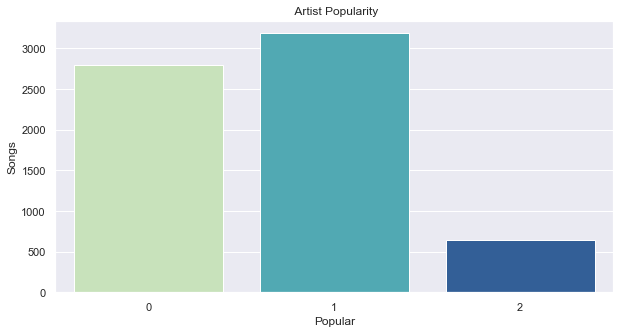

In [158]:
# Exploring Class Imbalance
print('Target Variable')
print(Top_Genre.groupby(["Popular"]).Popular.count())
print("\n")
print("0 = Unpopular")
print("1 = Popular")
print("2 = Very Popular")

# Target Variable Countplot
plt.figure(figsize = (10, 5))
sns.countplot(Top_Genre["Popular"], alpha = 1, palette = "YlGnBu")
plt.title(" Artist Popularity")
plt.ylabel("Songs")
plt.show()

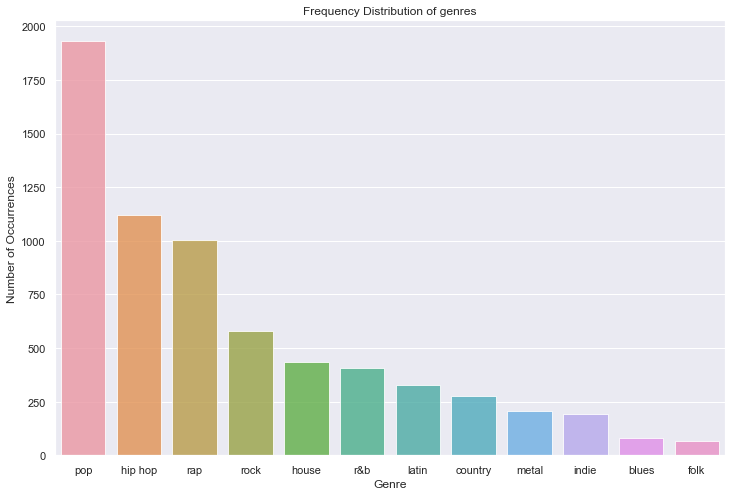

In [145]:
plt.figure(figsize=(12,8))
genre_count = spotifinal["artist_genres"].value_counts()
sns.set(style="darkgrid")
sns.barplot(genre_count.index, genre_count.values, alpha=0.8)
plt.title('Frequency Distribution of genres')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.show()

In [101]:
from wordcloud import WordCloud, STOPWORDS


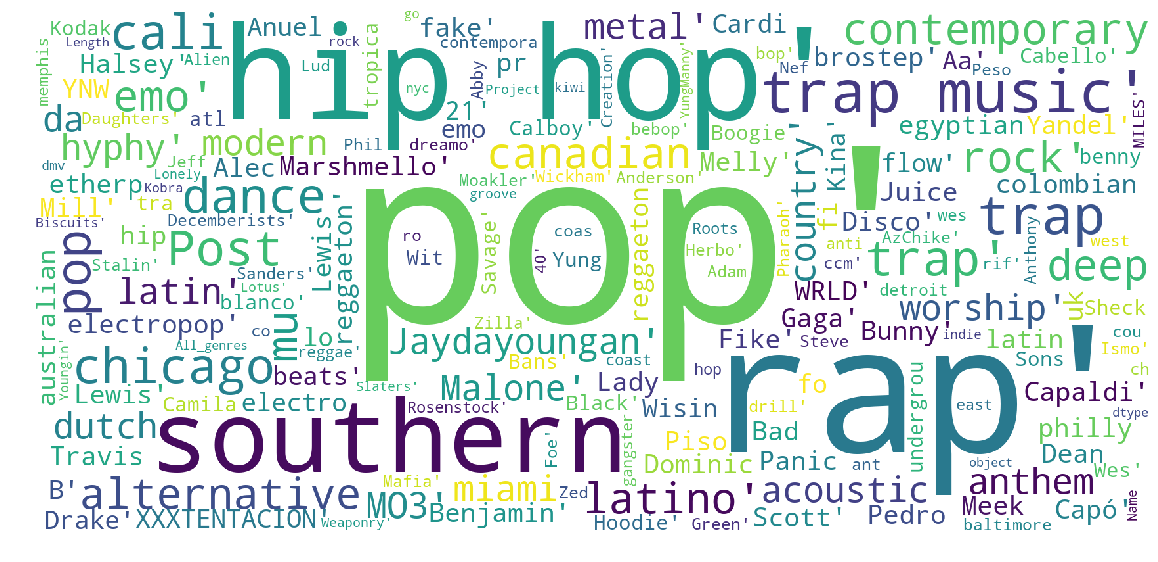

In [107]:

sns.set_style('darkgrid')
wordcloud = WordCloud(width = 1700, height = 800, 
                background_color ='white',  
                min_font_size = 10).generate(str(spotifinal.All_genres)) 
# Generate plot of most popular genre 
plt.figure(figsize = (20, 10), facecolor = None) 
plt.tight_layout(pad = 0) 
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

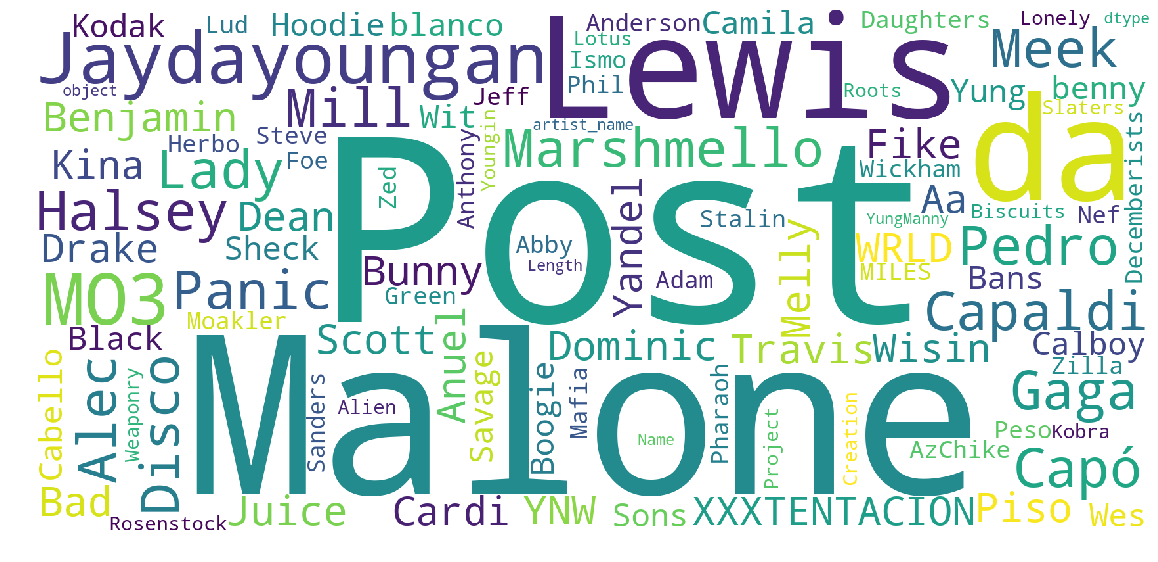

In [138]:
sns.set_style('darkgrid')
wordcloud = WordCloud(width = 1700, height = 800, 
                background_color ='white',  
                min_font_size = 10).generate(str(spotifinal.artist_name)) 
# Generate plot of most popular genre 
plt.figure(figsize = (20, 10), facecolor = None) 
plt.tight_layout(pad = 0) 
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


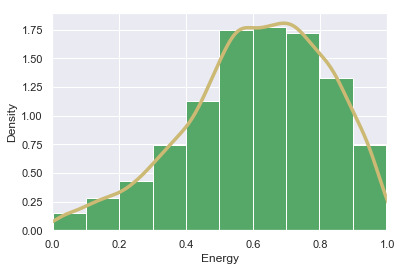

In [205]:
# Energy histogram

spotifinal["energy"].plot.hist(normed = True, color = 'g')
spotifinal["energy"].plot.kde(linewidth = 3.5, color = 'y')
plt.xlim(0, 1)
plt.xlabel('Energy', fontsize=12)


plt.show()

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


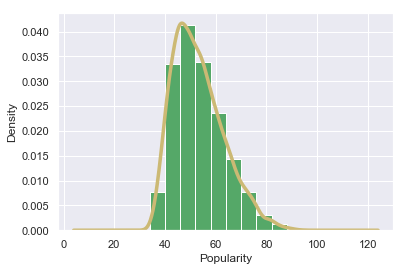

In [199]:
# Popularity histogram
spotidata["popularity"].plot.hist(normed = True, color = 'g')
spotidata["popularity"].plot.kde(linewidth = 3.5, color = 'y')
plt.xlabel('Popularity', fontsize=12)
plt.show()

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


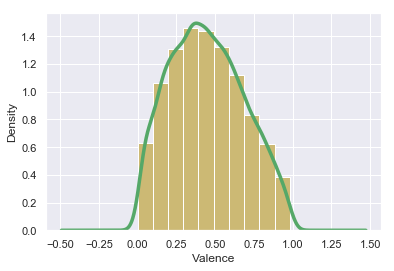

In [204]:
# Valence histogram
spotidata["valence"].plot.hist(normed = True, color = 'y')
spotidata["valence"].plot.kde(linewidth = 3.5, color = 'g')
plt.xlabel('Valence', fontsize=12)


plt.show()

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


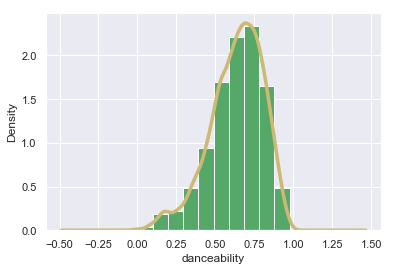

In [203]:
# danceability histogram
spotidata["danceability"].plot.hist(normed = True, color = 'g')
spotidata["danceability"].plot.kde(linewidth = 3.5, color = 'y')
plt.xlabel('danceability', fontsize=12)


plt.show()

In [143]:
# spotifinal.columns
#spotifinal[spotifinal['track_name']]
# spotifinal
# spotifinal.track_name
# spotifinal['track_name']
with pd.option_context("display.max_rows", 1000):
    display(spotifinal[['track_name','artist_name','artist_genres']])

,track_name,artist_name,artist_genres
0,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,pop
1,Calma - Remix,Pedro Capó,pop
2,Shallow,Lady Gaga,pop
3,Without Me,Halsey,pop
4,Happier,Marshmello,house
5,Someone You Loved,Lewis Capaldi,pop
6,High Hopes,Panic! At The Disco,rock
7,Going Bad (feat. Drake),Meek Mill,hip hop
8,Let Me Down Slowly,Alec Benjamin,pop
9,Better Now,Post Malone,pop


<h1>- Model  <h2> Cosine Similarity 

In [81]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

In [82]:
# instantiating and generating the count matrix
count = CountVectorizer()
count_matrix = count.fit_transform(spotifinal['artist_genres'])

# creating a Series for the song titles so they are associated to an ordered numerical
# list I will use later to match the indexes
indices = pd.Series(spotifinal.track_name)
indices[:5]

0    Sunflower - Spider-Man: Into the Spider-Verse
1                                    Calma - Remix
2                                          Shallow
3                                       Without Me
4                                          Happier
Name: track_name, dtype: object

In [83]:
# generating the cosine similarity matrix
cosine_sim = cosine_similarity(count_matrix, count_matrix)
cosine_sim

array([[1., 1., 1., ..., 0., 1., 0.],
       [1., 1., 1., ..., 0., 1., 0.],
       [1., 1., 1., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 1.],
       [1., 1., 1., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 1.]])

<h1>- Input Songs for recommendation

In [91]:
# function that takes in song title as input and returns the top 10 recommended songs
def recommendations(title, cosine_sim = cosine_sim):
    
    recommended_songs = []
    
    # gettin the index of the song that matches the title
    idx = indices[indices == title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar songs
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    # populating the list with the titles of the best 10 matching songs
    for i in top_10_indexes:
        recommended_songs.append(list(spotifinal.track_name)[i])
        
    return recommended_songs

In [139]:
recommendations('Amanece')

['Bad Bunny - ¿Cual es tu plan? - latin',
 "Miky Woodz - Na' Personal - latin",
 'Maluma - Mala Mía - latin',
 'Aldo Trujillo - Todos Hablan, Nada Saben - latin',
 'J Balvin - Ambiente - latin',
 'CNCO - Se Vuelve Loca - latin',
 'Wisin & Yandel - Aullando - latin',
 'Bad Bunny - 200 Mph - latin',
 'Daddy Yankee - Dura - Remix - latin',
 'Cosculluela - Madura (feat. Bad Bunny) - latin']

In [86]:
#spotifinal.loc[spotifinal['track_name'] == 'Mi Gente']

In [103]:
# instantiating and generating the count matrix with multiple variables 
count = CountVectorizer()
count_matrix = count.fit_transform(spotifinal['artist_genres'])

# creating a Series for the song titles so they are associated to an ordered numerical
# list I will use later to match the indexes
indices = pd.Series(spotifinal.track_name)
indices[:5]

0    Sunflower - Spider-Man: Into the Spider-Verse
1                                    Calma - Remix
2                                          Shallow
3                                       Without Me
4                                          Happier
Name: track_name, dtype: object

In [104]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)
cosine_sim

array([[1., 1., 1., ..., 0., 1., 0.],
       [1., 1., 1., ..., 0., 1., 0.],
       [1., 1., 1., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 1.],
       [1., 1., 1., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 1.]])

In [105]:
count_matrix.shape

(6629, 12)

In [106]:
# sample = np.append(count_matrix[0].A ,spotifinal['Popular'][0])
# #count_matrix[0].A = numpy.append(count_matrixX[0].A , 2)
# sample

In [107]:
#count_matrix[0].A = numpy.append(count_matrixX[0].A , 2)
count_matrix.A
count_multiple_matrix = np.c_[count_matrix.A , spotifinal[['Popular','danceability','energy','valence']]]

In [108]:
a = count_multiple_matrix
print(a)

[[0.    0.    0.    ... 0.76  0.479 0.913]
 [0.    0.    0.    ... 0.826 0.773 0.761]
 [0.    0.    0.    ... 0.572 0.385 0.323]
 ...
 [0.    0.    0.    ... 0.645 0.632 0.49 ]
 [0.    0.    0.    ... 0.785 0.517 0.42 ]
 [0.    0.    0.    ... 0.786 0.572 0.646]]


In [109]:
count_multiple_matrix.shape

(6629, 16)

In [110]:
# generating the cosine similarity matrix
cosine_sim = cosine_similarity(count_multiple_matrix, count_multiple_matrix)
cosine_sim

array([[1.        , 0.99169266, 0.97156738, ..., 0.33570525, 0.60232204,
        0.36891173],
       [0.99169266, 1.        , 0.97244311, ..., 0.37130591, 0.62989586,
        0.39326487],
       [0.97156738, 0.97244311, 1.        , ..., 0.22751956, 0.5261341 ,
        0.24196518],
       ...,
       [0.33570525, 0.37130591, 0.22751956, ..., 1.        , 0.50486158,
        0.99156948],
       [0.60232204, 0.62989586, 0.5261341 , ..., 0.50486158, 1.        ,
        0.53675958],
       [0.36891173, 0.39326487, 0.24196518, ..., 0.99156948, 0.53675958,
        1.        ]])

In [115]:
# function that takes in song title as input and returns the top 10 recommended songs
def recommendations(title, cosine_sim = cosine_sim):
    
    recommended_songs = []
    
    # gettin the index of the song that matches the title
    idx = indices[indices == title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar songs
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    # populating the list with the titles of the best 10 matching songs
    for i in top_10_indexes:
        recommended_songs.append(list(spotifinal.artist_name + ' - ' + spotifinal.track_name + ' - ' + spotifinal.artist_genres)[i])
        
    return recommended_songs

In [148]:
recommendations('Boomerang')

['Imagine Dragons - Birds - rock',
 'AJR - Burn the House Down - rock',
 'Imagine Dragons - Zero - From the Original Motion Picture "Ralph Breaks The Internet" - rock',
 'The 1975 - Sincerity Is Scary - rock',
 'The 1975 - TOOTIMETOOTIMETOOTIME - rock',
 'The Rolling Stones - Sympathy For The Devil - 50th Anniversary Edition - rock',
 'Panic! At The Disco - Hey Look Ma, I Made It - rock',
 'Panic! At The Disco - Say Amen (Saturday Night) - rock',
 "The 1975 - It's Not Living (If It's Not With You) - rock",
 'Kina - Get You The Moon (feat. Snøw) - rock']

In [113]:
# # function that takes in song title as input and returns the top 10 recommended songs
# def recommendations(title, cosine_sim = cosine_sim):
    
#     recommended_songs = []
    
#     # gettin the index of the song that matches the title
#     idx = indices[indices == title].index[0]

#     # creating a Series with the similarity scores in descending order
#     score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

#     # getting the indexes of the 10 most similar songs
#     top_10_indexes = list(score_series.iloc[1:11].index)
    
#     # populating the list with the titles of the best 10 matching songs
#     for i in top_10_indexes:
#         recommended_songs.append(list(spotifinal.artist_name + ' - ' + spotifinal.track_name + ' - ' + spotifinal.artist_genres))[i]
        
#     return recommended_songs

## Add Widget Input

In [824]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

In [902]:
# function that takes in song title as input and returns the top 10 recommended songs
def recommendations(title, cosine_sim = cosine_sim):
    
    recommended_songs = []
    
    # gettin the index of the song that matches the title
    idx = indices[indices == title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar songs
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    # populating the list with the titles of the best 10 matching songs
    for i in top_10_indexes:
        recommended_songs.append(list(spotifinal.track_name)[i])
        
    return recommended_songs

In [60]:
x = input()

Amanece


In [61]:
recommendations(x)

['Bad Bunny - Ser Bichote - latin',
 'Ozuna - Solita - latin',
 'Anuel Aa - Brindemos - latin',
 "Miky Woodz - Na' Personal - latin",
 'Bad Bunny - ¿Cual es tu plan? - latin',
 'Chris Jeday - Bipolar - latin',
 'Brytiago - Asesina - Remix - latin',
 'Chris Jeday - Ahora Dice - Real Hasta La Muerte Remix - latin',
 'Bad Bunny - Cuando Perriabas - latin',
 'Leslie Grace - Duro y Suave - latin']

In [65]:
cid = cid
secret = secret
username= username

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

artist_name = []
track_name = []
track_id = [] 
popularity = []
album_name = []


for i in range(0,10000,50):
    genre_pop_results = sp.search(q='genre:pop', type='track', limit=50,offset=i)
    for i, t in enumerate(genre_pop_results['tracks']['items']):
        artist_name.append(t['artists'][0]['name'])
        track_name.append(t['name'])
        track_id.append(t['id'])
        popularity.append(t['popularity'])
        album_name.append(t['album']['name'])
      
      

In [64]:
track_name

['bad guy',
 "I Don't Care (with Justin Bieber)",
 "If I Can't Have You",
 'Sunflower - Spider-Man: Into the Spider-Verse',
 'Truth Hurts',
 'EARFQUAKE',
 'Sucker',
 'Wow.',
 'Paradise',
 'Talk',
 'The London (feat. J. Cole & Travis Scott)',
 'SICKO MODE',
 "break up with your girlfriend, i'm bored",
 'Cross Me (feat. Chance the Rapper & PnB Rock)',
 'Never Really Over',
 'wish you were gay',
 'MIDDLE CHILD',
 'thank u, next',
 '7 rings',
 'Dancing With A Stranger (with Normani)',
 'Better',
 'Without Me',
 'Going Bad (feat. Drake)',
 'ME! (feat. Brendon Urie of Panic! At The Disco)',
 'Pure Water (with Migos)',
 'No Guidance (feat. Drake)',
 "i'm so tired...",
 'Boy With Luv (feat. Halsey)',
 'You Need To Calm Down',
 'Nightmare',
 'Money In The Grave (Drake ft. Rick Ross)',
 'Sweet but Psycho',
 "Mother's Daughter",
 'you should see me in a crown',
 'Talk',
 'Eastside (with Halsey & Khalid)',
 'Easier',
 'Go Loko',
 'Clout (feat. Cardi B)',
 'Happier',
 'Only Human',
 'Love Me Less (

In [740]:
df_genre_pop = pd.DataFrame({'artist_name':artist_name,'track_name':track_name,'album_name': album_name,'track_id':track_id,'popularity':popularity})
print(df_genre_pop.shape)
df_genre_pop



(0, 5)


,artist_name,track_name,album_name,track_id,popularity
